In [1]:

from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras import Model
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
import numpy as np
from sklearn import preprocessing
from bokeh.io import output_notebook
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import time
from keras.layers import Dense, LSTM, Dropout, Embedding,Flatten,Bidirectional, MaxPooling1D,GlobalAveragePooling1D, GlobalMaxPooling1D, AveragePooling1D,Conv1D
from keras.models import Sequential
from collections import defaultdict
from keras import regularizers
from pprint import pprint
from textwrap import wrap
import json
from keras import optimizers
output_notebook()
%matplotlib inline

/Users/mirco/Documents/comparative-arguments/ve/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Loading BokehJS ...

#### Load and prepare data

In [2]:
vocab_size= 50000
maxlen = 20
output_name_prefix = ''

In [3]:
def load_data(path_file, data_file, remove_no_path=False):
    frame = pd.read_csv(path_file)
    if remove_no_path:
        frame = frame[(frame.path != 'NOPATH')]
    #frame = frame[frame.most_frequent_percentage >= 0.6]
    data_frame = pd.read_csv(data_file)
    data_frame = data_frame[data_frame.sentence.isin(frame.sentence.values.tolist())]
    print('Paths: {} | Data: {}'.format(len(frame),len(data_frame)))
    return frame, data_frame


In [4]:
def preprocess(path_frame,reshaped=False):
    # transform labels into 3d tensors for lstm
    paths_list = path_frame['path'].values.tolist()
    tokenizer = Tokenizer(num_words=vocab_size,filters='', split=' ')
    tokenizer.fit_on_texts(paths_list)
    input_train = tokenizer.texts_to_sequences(paths_list)
    input_train = sequence.pad_sequences(input_train, maxlen=maxlen)

    # create target labels, one for each path
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(paths_list)
    y_train =  to_categorical(label_encoder.transform(paths_list))
    if reshaped:
        input_train =  input_train.reshape((len(paths_list),maxlen,1))
    pprint('Tokens {}'.format(len(tokenizer.word_counts)))
    print('{} paths total'.format(len(paths_list)))
    print('{} different (target) paths'.format(y_train[0].shape[0]))
    return input_train, y_train


#### Train the network

In [5]:
def plot_lines(history, first,second):
    plt.plot(history.history[first[0]],color=first[1])
    plt.plot(history.history[second[0]],linestyle='--',color=second[1])
    plt.title('{} vs {}'.format(first[0],second[0]))
    plt.xlabel('epoch')
    plt.legend([first[0],second[0]])
    plt.figure(figsize=(5,5))
    plt.show()
    

In [6]:
def train_model(layers,X,y,name='',epochs=100,batch_size=64, shuffle=True, validation_split=0.4, optimizer='rmsprop',
               activation_last_layer='softmax'):
    model = Sequential(name=name)
    [model.add(layer) for layer in layers]
    model.add(Dense(y[0].shape[0],activation=activation_last_layer))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
    model.summary()
    history = model.fit(X, y,
    epochs=epochs, batch_size=batch_size,shuffle=shuffle, validation_split=validation_split)
    return history, model
    

#### Prepare the embeddings

In [7]:
def get_embeddings(model,X):
    layer = list(filter(lambda x: x.name == 'embedding',model.layers))[0]
    print(layer)
    assert layer.name == 'embedding'
    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=layer.output)
    return intermediate_layer_model.predict(X)

### Average Embedding

In [8]:
def average_embeddings(embeddings,path_frame,data_frame):
    assert len(path_frame) == len(embeddings)
    embedding_dict = defaultdict(list)
    mean_embedding_dict = {}
    idx = 0
    for i, row in path_frame.iterrows():
        embedding_dict[row['sentence']].append(embeddings[idx])
        idx += 1
    print(len(embedding_dict), len(data_frame))
    assert len(embedding_dict)== len(data_frame)

    for k,v in embedding_dict.items():
        adder = np.zeros(v[0].shape)
        for val in v:
            adder += val
        adder /= len(v)
        mean_embedding_dict[k] = adder

    assert len(mean_embedding_dict)== len(data_frame)
    return mean_embedding_dict

In [9]:
def reformat(mean_embedding_dict,path_frame,data_frame):
    X = []
    y = []
    plot_data = []
    plot_x = []
    idx = 0
    embedding_df = pd.DataFrame(columns=['id', 'sentence', 'label', 'embedding', 'paths'])
    for k,v in mean_embedding_dict.items():
        f_slice = path_frame[path_frame.sentence == k]
        label = f_slice.most_frequent_label.values.tolist()[0]
        f_paths = f_slice.path.values.tolist()
        embedding_df.loc[idx] = [f_slice.id.values.tolist()[0], wrap(f_slice.sentence.values.tolist()[0]),label,
                                 v.reshape(-1,1).squeeze().tolist(), [wrap(p) for p in f_paths]]
        idx+=1
        # prepare results for classification
        X.append(v.reshape(-1,1).squeeze().tolist())
        y.append(label)

        # prepare results for t-sne plot
        plot_x.append(v)
        plot_data.append( (label,k,'\n'.join(f_paths)) )
    return X, y, plot_data, plot_x, embedding_df

In [10]:
def save_embedding_df(embedding_df,name):
    embedding_df.to_csv('combi_'+name+".csv")

### Plot

In [11]:
def tsne_plot(plot_x, plot_data):
    X_embedded = TSNE(n_components=2,verbose=1).fit_transform(plot_x)
    plot_frame = pd.DataFrame(columns=['x','y','class','sentence', 'path'])
    for i,x in enumerate(X_embedded):
        plot_frame.loc[i] = [x[0],x[1],plot_data[i][0],plot_data[i][1],plot_data[i][2]]

    def build_source(label, df):
        df = df[df['class'] == label]
        return ColumnDataSource(data=dict(
        x=df.x.values.tolist(),
        y=df.y.values.tolist(),
        sentence=df.sentence.tolist(),
        path=df.path.tolist(),
        label=df['class'].tolist()))

    colormap = {'WORSE': 'red', 'BETTER': 'green', 'NONE': 'blue'}
    colors = [colormap[x] for x in plot_frame['class']]

    # GROUP tooltips
    hover = HoverTool(tooltips=[
        ("Sentence", "@sentence"),
        ("Path", "@path"),
        ("label", "@label"),
    ])

    p = figure(plot_width=900,  plot_height=900, tools="pan,wheel_zoom,box_zoom,reset,previewsave")
    p.add_tools(hover)

    p.cross(x='x', y='y', source=build_source('NONE', plot_frame),size=5,color='gray')
    p.circle(x='x', y='y', source=build_source('WORSE', plot_frame) ,size=5,color='red')
    p.circle(x='x', y='y', source=build_source('BETTER', plot_frame),size=5,color='green')
    return p

### Classification Test

In [12]:
def classification_test(X,y,data_frame,with_embeddings=False):
    _X = X
    if with_embeddings:
        print("With embeddings")
        lst_lst = np.array([json.loads(l) for l in data_frame.embedding_middle_part.values.tolist()])
        paths_ = np.asarray(X)
        infersent_ = np.array(lst_lst)
        _X = np.concatenate([paths_, infersent_],axis=1)
        assert np.asarray(X).shape[0] == paths_.shape[0] == infersent_.shape[0]
        assert _X.shape[1] == paths_.shape[1] + infersent_.shape[1]
        
    else:
        print("Without embeddings")
    
    kf = StratifiedKFold(n_splits=2, random_state=42)
    
    d = defaultdict(int)

    for train_index, test_index in kf.split(_X,y):
        X_train, X_test = np.array(_X)[train_index], np.array(_X)[test_index]
        y_train, y_test = np.array(y)[train_index], np.array(y)[test_index]
     
        log = LogisticRegression()
        log.fit(X_train, y_train)
        pred = log.predict(X_test)
        print(classification_report(y_test,pred,labels=['BETTER', 'WORSE', 'NONE']))
        print('=========\n')
        print("\n\n")

In [13]:
def full_run(layers,path_file,
             name='',reshape=False,epochs=100,batch_size=64, shuffle=True, validation_split=0.2, optimizer='rmsprop'
             ,activation_last_layer='softmax'):
    start = time.mktime(time.localtime())
    h_path_frame, h_data_frame = load_data('../code/data/do-not-touch/pre_path_{}.csv'.format(path_file),
                                           '../code/data/do-not-touch/held-out-data.csv', remove_no_path=False)
    
    path_frame, data_frame = load_data('../code/data/pre_path_{}.csv'.format(path_file),
                                           '../code/data/data.csv', remove_no_path=False)
    
    path_frame = pd.concat([h_path_frame,path_frame])
    data_frame = pd.concat([h_data_frame,data_frame])
    
    
    X, y = preprocess(path_frame,reshaped=reshape)
    history, trained_model = train_model(layers,X,y, name=name,epochs=epochs,batch_size=batch_size,
                                         shuffle=shuffle,activation_last_layer=activation_last_layer, validation_split=validation_split, optimizer=optimizer)

    plot_lines(history,('acc','green'),('val_acc', 'yellowgreen'))
    plot_lines(history,('loss', 'red'), ('val_loss', 'orangered'))
    embeddings = get_embeddings(trained_model,X)
    mean_embedding_dict = average_embeddings(embeddings,path_frame,data_frame)
    _X, _y, plot_data, plot_x, embedding_df = reformat(mean_embedding_dict,path_frame,data_frame)
    classification_test(_X,_y,data_frame)
    #classification_test(_X,_y,data_frame,with_embeddings=True)
    save_embedding_df(embedding_df,name)
    show(tsne_plot(plot_x, plot_data))
    
    duration = (time.mktime(time.localtime()) - start) / 60
    print('Took {} minutes'.format(duration))
    return trained_model

=========== full_paths_original_4
Paths: 1758 | Data: 1440
Paths: 7225 | Data: 5759
'Tokens 2173'
8983 paths total
2856 different (target) paths
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 100)           5000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 200)           240800    
_________________________________________________________________
embedding (GlobalMaxPooling1 (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2856)              574056    
Total params: 5,814,856
Trainable params: 5,814,856
Non-trainable params: 0
_________________________________________________________________
Train on 7186 samples, validate on 1797 samples
Epoch 1/150
7186/7186 [==============================] - 22s 3ms/step -

7186/7186 [==============================] - 19s 3ms/step - loss: 0.5185 - acc: 0.9107 - val_loss: 5.0186 - val_acc: 0.6772
Epoch 54/150
7186/7186 [==============================] - 19s 3ms/step - loss: 0.4937 - acc: 0.9136 - val_loss: 5.0056 - val_acc: 0.6789
Epoch 55/150
7186/7186 [==============================] - 19s 3ms/step - loss: 0.4777 - acc: 0.9164 - val_loss: 5.0143 - val_acc: 0.6778
Epoch 56/150
7186/7186 [==============================] - 21s 3ms/step - loss: 0.4531 - acc: 0.9223 - val_loss: 5.0434 - val_acc: 0.6784
Epoch 57/150
7186/7186 [==============================] - 21s 3ms/step - loss: 0.4366 - acc: 0.9278 - val_loss: 5.0427 - val_acc: 0.6806
Epoch 58/150
7186/7186 [==============================] - 19s 3ms/step - loss: 0.4165 - acc: 0.9281 - val_loss: 5.0022 - val_acc: 0.6806
Epoch 59/150
7186/7186 [==============================] - 21s 3ms/step - loss: 0.3972 - acc: 0.9338 - val_loss: 5.0086 - val_acc: 0.6795
Epoch 60/150
7186/7186 [==============================

Epoch 113/150
7186/7186 [==============================] - 20s 3ms/step - loss: 0.0253 - acc: 0.9989 - val_loss: 4.8565 - val_acc: 0.6828
Epoch 114/150
7186/7186 [==============================] - 20s 3ms/step - loss: 0.0229 - acc: 0.9989 - val_loss: 4.8555 - val_acc: 0.6828
Epoch 115/150
7186/7186 [==============================] - 20s 3ms/step - loss: 0.0218 - acc: 0.9994 - val_loss: 4.8681 - val_acc: 0.6828
Epoch 116/150
7186/7186 [==============================] - 19s 3ms/step - loss: 0.0205 - acc: 0.9997 - val_loss: 4.8562 - val_acc: 0.6828
Epoch 117/150
7186/7186 [==============================] - 20s 3ms/step - loss: 0.0199 - acc: 0.9993 - val_loss: 4.8577 - val_acc: 0.6828
Epoch 118/150
7186/7186 [==============================] - 19s 3ms/step - loss: 0.0188 - acc: 0.9996 - val_loss: 4.8221 - val_acc: 0.6828
Epoch 119/150
7186/7186 [==============================] - 19s 3ms/step - loss: 0.0175 - acc: 0.9993 - val_loss: 4.7078 - val_acc: 0.6828
Epoch 120/150
7186/7186 [=========

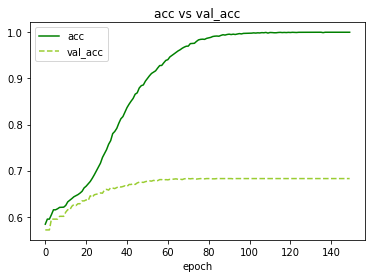

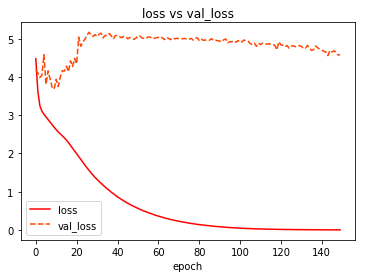

7199 7199
Without embeddings
             precision    recall  f1-score   support

     BETTER       0.55      0.19      0.28       682
      WORSE       0.29      0.03      0.06       297
       NONE       0.76      0.97      0.85      2621

avg / total       0.68      0.74      0.68      3600





             precision    recall  f1-score   support

     BETTER       0.66      0.19      0.30       682
      WORSE       0.36      0.07      0.11       296
       NONE       0.77      0.98      0.86      2621

avg / total       0.71      0.75      0.69      3599





[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7199 samples in 0.134s...
[t-SNE] Computed neighbors for 7199 samples in 11.999s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7199
[t-SNE] Computed conditional probabilities for sample 2000 / 7199
[t-SNE] Computed conditional probabilities for sample 3000 / 7199
[t-SNE] Computed conditional probabilities for sample 4000 / 7199
[t-SNE] Computed cond

Took 56.03333333333333 minutes
=========== middle_paths_unrestricted_16
Paths: 2513 | Data: 1440
Paths: 10028 | Data: 5759
'Tokens 4514'
12541 paths total
5374 different (target) paths
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 100)           5000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 200)           240800    
_________________________________________________________________
embedding (GlobalMaxPooling1 (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5374)              1080174   
Total params: 6,320,974
Trainable params: 6,320,974
Non-trainable params: 0
_________________________________________________________________
Train on 10032 samples, validate on 2509 samples
Epoch 1/150
10032/10032 [=====

10032/10032 [==============================] - 32s 3ms/step - loss: 0.7731 - acc: 0.8867 - val_loss: 6.1798 - val_acc: 0.5931
Epoch 53/150
10032/10032 [==============================] - 32s 3ms/step - loss: 0.7381 - acc: 0.8971 - val_loss: 6.1167 - val_acc: 0.5927
Epoch 54/150
10032/10032 [==============================] - 32s 3ms/step - loss: 0.7037 - acc: 0.9012 - val_loss: 6.1656 - val_acc: 0.5943
Epoch 55/150
10032/10032 [==============================] - 32s 3ms/step - loss: 0.6692 - acc: 0.9106 - val_loss: 6.1509 - val_acc: 0.5951
Epoch 56/150
10032/10032 [==============================] - 32s 3ms/step - loss: 0.6396 - acc: 0.9145 - val_loss: 6.1482 - val_acc: 0.5971
Epoch 57/150
10032/10032 [==============================] - 32s 3ms/step - loss: 0.6075 - acc: 0.9220 - val_loss: 6.1298 - val_acc: 0.5974
Epoch 58/150
10032/10032 [==============================] - 32s 3ms/step - loss: 0.5772 - acc: 0.9282 - val_loss: 6.1280 - val_acc: 0.5982
Epoch 59/150
10032/10032 [==============

Epoch 111/150
10032/10032 [==============================] - 31s 3ms/step - loss: 0.0158 - acc: 0.9998 - val_loss: 5.6170 - val_acc: 0.6006
Epoch 112/150
10032/10032 [==============================] - 32s 3ms/step - loss: 0.0137 - acc: 1.0000 - val_loss: 5.7207 - val_acc: 0.6006
Epoch 113/150
10032/10032 [==============================] - 31s 3ms/step - loss: 0.0126 - acc: 0.9999 - val_loss: 5.8268 - val_acc: 0.6006
Epoch 114/150
10032/10032 [==============================] - 31s 3ms/step - loss: 0.0116 - acc: 1.0000 - val_loss: 5.7956 - val_acc: 0.6006
Epoch 115/150
10032/10032 [==============================] - 36s 4ms/step - loss: 0.0104 - acc: 1.0000 - val_loss: 5.5851 - val_acc: 0.6006
Epoch 116/150
10032/10032 [==============================] - 36s 4ms/step - loss: 0.0094 - acc: 1.0000 - val_loss: 5.8184 - val_acc: 0.6006
Epoch 117/150
10032/10032 [==============================] - 32s 3ms/step - loss: 0.0091 - acc: 0.9999 - val_loss: 5.4910 - val_acc: 0.6006
Epoch 118/150
10032/

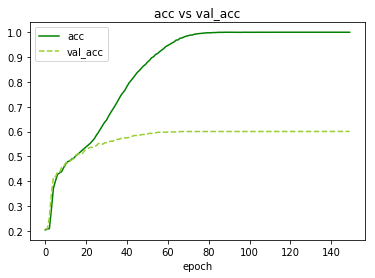

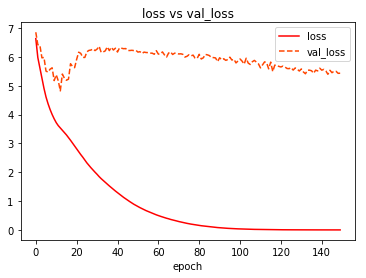

7199 7199
Without embeddings
             precision    recall  f1-score   support

     BETTER       0.61      0.61      0.61       682
      WORSE       0.39      0.11      0.17       297
       NONE       0.86      0.93      0.89      2621

avg / total       0.77      0.80      0.78      3600





             precision    recall  f1-score   support

     BETTER       0.68      0.55      0.61       682
      WORSE       0.36      0.14      0.20       296
       NONE       0.85      0.95      0.89      2621

avg / total       0.77      0.80      0.78      3599





[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7199 samples in 0.070s...
[t-SNE] Computed neighbors for 7199 samples in 13.205s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7199
[t-SNE] Computed conditional probabilities for sample 2000 / 7199
[t-SNE] Computed conditional probabilities for sample 3000 / 7199
[t-SNE] Computed conditional probabilities for sample 4000 / 7199
[t-SNE] Computed cond

Took 89.06666666666666 minutes


In [14]:
#full_orig = ['full_paths_original_4', 'full_paths_original_8', 'full_paths_original_16']
#full_unres = ['full_paths_unrestricted_4', 'full_paths_unrestricted_8','full_paths_unrestricted_16']
#middle_orig = ['middle_paths_original_4', 'middle_paths_original_8', 'middle_paths_original_16']
#middle_unres = ['middle_paths_unrestricted_4', 'middle_paths_unrestricted_8', 'middle_paths_unrestricted_16']
for x in ['full_paths_original_4','middle_paths_unrestricted_16']: #'full_paths_original_4',

    pf = x
    name = x
    print('=========== {}'.format(name))
    lstm = 200
    model = full_run([
            Embedding(vocab_size,100,input_length=maxlen, input_shape=(maxlen, )),
            LSTM(lstm,return_sequences=True),
            GlobalMaxPooling1D(name='embedding'),
    ], pf,
        epochs=150,optimizer='rmsprop',batch_size=128,name=name)

